In [1]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pickle
import pandas as pd
from sklearn.model_selection import KFold

import lime
from lime import lime_tabular

import warnings
warnings.filterwarnings('ignore')
import json
import pickle
import seaborn as sn

In [2]:
data_type = 'caco'
feature_type = 'maccs'

## Load data

In [3]:
exp_rf = pd.read_csv(f'../explanations/explanations_{data_type}_{feature_type}_rf.csv')
exp_hist = pd.read_csv(f'../explanations/explanations_{data_type}_{feature_type}_hist.csv')
exp_lgbm = pd.read_csv(f'../explanations/explanations_{data_type}_{feature_type}_lgbm.csv')
exp_xgboost = pd.read_csv(f'../explanations/explanations_{data_type}_{feature_type}_xgboost.csv')
exp_svr = pd.read_csv(f'../explanations/explanations_{data_type}_{feature_type}_svr.csv')

In [4]:
with open('../../maccs_keys_dict.pickle', 'rb') as fp:
    Maccs_keys_dict = pickle.load(fp)

In [5]:
def map_to_smarts(df):
    df_mapped = df + 1
    df_mapped = df_mapped.applymap(lambda x: Maccs_keys_dict[x][0])
    return df_mapped

## Lime - aggregation by score 

In [6]:
def get_scores(explanations, len_data):
    scores = np.zeros(166)
    for index, exp in explanations.iterrows():
        num, score = int(exp['0']), exp['1']
        scores[num] += abs(score)
    scores /= len_data
    return scores

In [7]:
def get_top_k(explanations, k, len_data):
    scores = get_scores(explanations, len_data)
    top_f = np.argsort(abs(scores))[::-1]
    return top_f[:k]

In [9]:
k = 10
#df_top_5 = get_top_k(exp_rf, k, len(X))
len_data = 1000
top_10 = pd.DataFrame({'Random_forest': list(get_top_k(exp_rf, k, len_data)), 'Hist': list(get_top_k(exp_hist, k, len_data)), 'Lgbm': list(get_top_k(exp_lgbm, k, len_data)), 'Xgboost': list(get_top_k(exp_xgboost, k, len_data)), 'SVR': list(get_top_k(exp_svr, k, len_data))})
top_10

,Random_forest,Hist,Lgbm,Xgboost,SVR
0,36,130,67,67,130
1,130,67,132,132,51
2,51,36,125,77,123
3,67,51,51,51,42
4,44,89,130,130,15
5,33,44,44,89,67
6,24,154,128,154,83
7,38,139,58,125,52
8,145,38,154,36,70
9,28,42,33,42,138


In [10]:
top_10_smarts = map_to_smarts(top_10)
top_10_smarts.to_csv(f'files/{data_type}/{data_type}_{feature_type}_agg_by_score.csv', index=False)
top_10_smarts

,Random_forest,Hist,Lgbm,Xgboost,SVR
0,[#7]~[#6](~[#8])~[#7],[!#6;!#1;!H0],[!#6;!#1;!H0]~[!#6;!#1;!H0],[!#6;!#1;!H0]~[!#6;!#1;!H0],[!#6;!#1;!H0]
1,[!#6;!#1;!H0],[!#6;!#1;!H0]~[!#6;!#1;!H0],*@*!@[#7],*@*!@[#7],[#7]~[#7]
2,[#7]~[#7],[#7]~[#6](~[#8])~[#7],*!@[#8]!@*,[#6]=[#7],[!#6;!#1]~[!#6;!#1]
3,[!#6;!#1;!H0]~[!#6;!#1;!H0],[#7]~[#7],[#7]~[#7],[#7]~[#7],[!#6;!#1;!H0]~*~[!#6;!#1;!H0]
4,[#6]=[#6]~[#7],"[$([!#6;!#1;!H0]~*~*~[CH2]~*),$([!#6;!#1;!H0;R...",[!#6;!#1;!H0],[!#6;!#1;!H0],[!#6;!#1]1~*~*~1
5,[CH2]=*,[#6]=[#6]~[#7],[#6]=[#6]~[#7],"[$([!#6;!#1;!H0]~*~*~[CH2]~*),$([!#6;!#1;!H0;R...",[!#6;!#1;!H0]~[!#6;!#1;!H0]
6,[#7]~[#6](~[#7])~[#7],*!@[CH2]!@*,"[$(*~[CH2]~*~*~[CH2]~*),$([R]1@[CH2]@[R]@[R]@[...",*!@[CH2]!@*,[NH2]
7,[#8]~[#16](~[#8])~[#8],[#8],[#16]!:*:*,*!@[#8]!@*,[!#6;!#1;!H0]~*~*~*~[!#6;!#1;!H0]
8,[#8],[#8]~[#16](~[#8])~[#8],*!@[CH2]!@*,[#7]~[#6](~[#8])~[#7],[#7]~[#8]
9,[#15],[!#6;!#1;!H0]~*~[!#6;!#1;!H0],[CH2]=*,[!#6;!#1;!H0]~*~[!#6;!#1;!H0],[O;!H0]


## Lime - aggregation by top k

In [11]:
def get_scores_top_k(explanations, k, len_data):
    scores = np.zeros(166)
    top_ks = [explanations[x:x+k] for x in range(0, len(explanations), 166)]
    assert len(top_ks)==len_data
    for i in range(0,166):
        score = 0
        for top in top_ks:
            if i in list(top['0']): score +=1
        scores[i] = score
    scores /= len_data
    return scores

In [12]:
def get_top_k_top_k(explanations, k, len_data):
    scores = get_scores_top_k(explanations, k, len_data)
    top_f = np.argsort(scores)[::-1]
    return top_f[:k]

In [13]:
k = 10
topk_10 = pd.DataFrame({'Random_forest': list(get_top_k_top_k(exp_rf, k, len_data)), 'Hist': list(get_top_k_top_k(exp_hist, k, len_data)), 'Lgbm': list(get_top_k_top_k(exp_lgbm, k, len_data)), 'Xgboost': list(get_top_k_top_k(exp_xgboost, k, len_data)), 'SVR': list(get_top_k_top_k(exp_svr, k, len_data))})
topk_10

,Random_forest,Hist,Lgbm,Xgboost,SVR
0,130,130,125,132,42
1,44,51,67,51,123
2,51,36,51,89,51
3,36,67,132,130,15
4,67,89,130,77,130
5,33,44,58,67,67
6,145,139,33,125,83
7,24,154,154,154,52
8,38,38,128,36,70
9,28,33,44,42,138


In [14]:
topk_10_smarts = map_to_smarts(topk_10)
topk_10_smarts.to_csv(f'files/{data_type}/{data_type}_{feature_type}_agg_by_topk.csv', index=False)
topk_10_smarts

,Random_forest,Hist,Lgbm,Xgboost,SVR
0,[!#6;!#1;!H0],[!#6;!#1;!H0],*!@[#8]!@*,*@*!@[#7],[!#6;!#1;!H0]~*~[!#6;!#1;!H0]
1,[#6]=[#6]~[#7],[#7]~[#7],[!#6;!#1;!H0]~[!#6;!#1;!H0],[#7]~[#7],[!#6;!#1]~[!#6;!#1]
2,[#7]~[#7],[#7]~[#6](~[#8])~[#7],[#7]~[#7],"[$([!#6;!#1;!H0]~*~*~[CH2]~*),$([!#6;!#1;!H0;R...",[#7]~[#7]
3,[#7]~[#6](~[#8])~[#7],[!#6;!#1;!H0]~[!#6;!#1;!H0],*@*!@[#7],[!#6;!#1;!H0],[!#6;!#1]1~*~*~1
4,[!#6;!#1;!H0]~[!#6;!#1;!H0],"[$([!#6;!#1;!H0]~*~*~[CH2]~*),$([!#6;!#1;!H0;R...",[!#6;!#1;!H0],[#6]=[#7],[!#6;!#1;!H0]
5,[CH2]=*,[#6]=[#6]~[#7],[#16]!:*:*,[!#6;!#1;!H0]~[!#6;!#1;!H0],[!#6;!#1;!H0]~[!#6;!#1;!H0]
6,[#8],[#8],[CH2]=*,*!@[#8]!@*,[NH2]
7,[#7]~[#6](~[#7])~[#7],*!@[CH2]!@*,*!@[CH2]!@*,*!@[CH2]!@*,[!#6;!#1;!H0]~*~*~*~[!#6;!#1;!H0]
8,[#8]~[#16](~[#8])~[#8],[#8]~[#16](~[#8])~[#8],"[$(*~[CH2]~*~*~[CH2]~*),$([R]1@[CH2]@[R]@[R]@[...",[#7]~[#6](~[#8])~[#7],[#7]~[#8]
9,[#15],[CH2]=*,[#6]=[#6]~[#7],[!#6;!#1;!H0]~*~[!#6;!#1;!H0],[O;!H0]


## Lime - comparison of models

In [15]:
def get_scores_top_k_example(explanations, k, len_data):
    scores = np.zeros(166)
    top_ks = [explanations[x:x+k] for x in range(0, len(explanations), 166)]
    assert len(top_ks)==len_data
    return top_ks

In [16]:
def get_top_k_2models_score(explanations_1, explanations_2, k, len_data):
    top_ks_1 = get_scores_top_k_example(explanations_1, k, len_data)
    top_ks_2 = get_scores_top_k_example(explanations_2, k, len_data)
    scores = []
    for j in range(0,166):
        for i in range(len(top_ks_1)):
            score = len(set(top_ks_1[i]['0']).intersection(top_ks_2[i]['0']))
            score /= k
            scores.append(score)
    return np.mean(scores)

In [16]:
get_top_k_2models_score(exp_rf, exp_hist, 10, len_data)

0.5958

In [17]:
'''
models_list = [exp_rf, exp_hist, exp_lgbm, exp_xgboost, exp_svr]
scores = []
for i, exp in enumerate(models_list):
    for exp2 in models_list[i+1:]:
        scores.append(get_top_k_2models_score(exp, exp2, 10, len_data))
print(scores)
'''

'\nmodels_list = [exp_rf, exp_hist, exp_lgbm, exp_xgboost, exp_svr]\nscores = []\nfor i, exp in enumerate(models_list):\n    for exp2 in models_list[i+1:]:\n        scores.append(get_top_k_2models_score(exp, exp2, 10, len_data))\nprint(scores)\n'

In [17]:
models_list = [exp_rf, exp_hist, exp_lgbm, exp_xgboost, exp_svr]
scores = []
for i, exp in enumerate(models_list):
    for exp2 in models_list:
        scores.append(get_top_k_2models_score(exp, exp2, 10, len_data))
print(scores)

[1.0, 0.5958, 0.4075000000000001, 0.3934, 0.2952000000000001, 0.5958, 1.0, 0.5251999999999999, 0.5575000000000001, 0.3348999999999998, 0.4075000000000001, 0.5251999999999999, 1.0, 0.583, 0.3741, 0.3934, 0.5575000000000001, 0.583, 1.0, 0.3566, 0.2952000000000001, 0.3348999999999998, 0.3741, 0.3566, 1.0]


<AxesSubplot: >

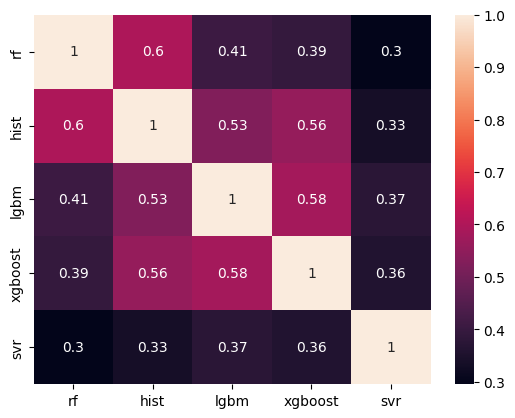

In [19]:
scores_arr = np.array(scores).reshape(5,5)
labels = ['rf', 'hist', 'lgbm', 'xgboost', 'svr']
heatmap_models = sn.heatmap(scores_arr, xticklabels=labels, yticklabels=labels, annot=True)
heatmap_models

In [20]:
fig = heatmap_models.get_figure()
fig.savefig(f"files/{data_type}/{data_type}_{feature_type}_models_heatmap.png") 

## Lime - comparison of models (features)

In [21]:
def get_top_k_2models(explanations_1, explanations_2, k, len_data):
    top_ks_1 = get_scores_top_k_example(explanations_1, k, len_data)
    top_ks_2 = get_scores_top_k_example(explanations_2, k, len_data)
    scores = np.zeros(166)
    for j in range(0,166):
        for i in range(len(top_ks_1)):
            common_fs = list(set(top_ks_1[i]['0']).intersection(top_ks_2[i]['0']))
            scores[common_fs] += 1
    scores /= len_data  
    top_f = np.argsort(scores)[::-1]
    return top_f[:k]

In [22]:
def get_top_k_more_models(explanations, k, len_data):
    top_ks = [get_scores_top_k_example(exp, k, len_data) for exp in explanations]
    scores = np.zeros(166)
    for j in range(0,166):
        for i in range(len(top_ks[0])):
            common_fs = list(set(top_ks[0][i]['0']).intersection(*[top[i]['0'] for top in top_ks]))
            scores[common_fs] += 1
    scores /= len_data  
    top_f = np.argsort(scores)[::-1]
    return top_f[:k]

In [23]:
#get_top_k_2models(exp_rf, exp_hist, 10, len_data)

In [23]:
models_list = [exp_rf, exp_hist, exp_lgbm, exp_xgboost, exp_svr]
labels = ['rf', 'hist', 'lgbm', 'xgboost', 'svr']
comp_models = pd.DataFrame()
for i, exp in enumerate(models_list):
    for j, exp2 in enumerate(models_list[i+1:]):
        column_name = labels[i] + '/' + labels[j+i+1]
        comp_models[column_name] = get_top_k_2models(exp, exp2, 10, len_data)
comp_models['all'] = get_top_k_more_models(models_list, 10, len_data)
comp_models

,rf/hist,rf/lgbm,rf/xgboost,rf/svr,hist/lgbm,hist/xgboost,hist/svr,lgbm/xgboost,lgbm/svr,xgboost/svr,all
0,51,51,51,130,67,51,130,132,51,51,51
1,36,67,130,51,51,130,51,51,67,130,130
2,130,130,67,67,130,89,67,67,130,67,67
3,67,33,36,28,154,67,42,125,125,42,165
4,44,44,89,47,44,36,125,130,42,125,50
5,33,36,145,38,132,154,52,154,138,15,57
6,89,38,38,52,33,132,28,89,83,47,56
7,38,26,26,26,89,46,47,42,26,77,55
8,26,89,46,70,36,125,38,36,47,38,54
9,145,154,100,56,42,38,70,77,56,26,53


In [24]:
comp_models_smarts = map_to_smarts(comp_models)
comp_models_smarts.to_csv(f'files/{data_type}/{data_type}_{feature_type}_models_comparison.csv', index=False)
comp_models_smarts

,rf/hist,rf/lgbm,rf/xgboost,rf/svr,hist/lgbm,hist/xgboost,hist/svr,lgbm/xgboost,lgbm/svr,xgboost/svr,all
0,[#7]~[#7],[#7]~[#7],[#7]~[#7],[!#6;!#1;!H0],[!#6;!#1;!H0]~[!#6;!#1;!H0],[#7]~[#7],[!#6;!#1;!H0],*@*!@[#7],[#7]~[#7],[#7]~[#7],[#7]~[#7]
1,[#7]~[#6](~[#8])~[#7],[!#6;!#1;!H0]~[!#6;!#1;!H0],[!#6;!#1;!H0],[#7]~[#7],[#7]~[#7],[!#6;!#1;!H0],[#7]~[#7],[#7]~[#7],[!#6;!#1;!H0]~[!#6;!#1;!H0],[!#6;!#1;!H0],[!#6;!#1;!H0]
2,[!#6;!#1;!H0],[!#6;!#1;!H0],[!#6;!#1;!H0]~[!#6;!#1;!H0],[!#6;!#1;!H0]~[!#6;!#1;!H0],[!#6;!#1;!H0],"[$([!#6;!#1;!H0]~*~*~[CH2]~*),$([!#6;!#1;!H0;R...",[!#6;!#1;!H0]~[!#6;!#1;!H0],[!#6;!#1;!H0]~[!#6;!#1;!H0],[!#6;!#1;!H0],[!#6;!#1;!H0]~[!#6;!#1;!H0],[!#6;!#1;!H0]~[!#6;!#1;!H0]
3,[!#6;!#1;!H0]~[!#6;!#1;!H0],[CH2]=*,[#7]~[#6](~[#8])~[#7],[#15],*!@[CH2]!@*,[!#6;!#1;!H0]~[!#6;!#1;!H0],[!#6;!#1;!H0]~*~[!#6;!#1;!H0],*!@[#8]!@*,*!@[#8]!@*,[!#6;!#1;!H0]~*~[!#6;!#1;!H0],?
4,[#6]=[#6]~[#7],[#6]=[#6]~[#7],"[$([!#6;!#1;!H0]~*~*~[CH2]~*),$([!#6;!#1;!H0;R...",[#8]~[!#6;!#1](~[#8])(~[#8]),[#6]=[#6]~[#7],[#7]~[#6](~[#8])~[#7],*!@[#8]!@*,[!#6;!#1;!H0],[!#6;!#1;!H0]~*~[!#6;!#1;!H0],*!@[#8]!@*,[#6]~[#16]~[#8]
5,[CH2]=*,[#7]~[#6](~[#8])~[#7],[#8],[#8]~[#16](~[#8])~[#8],*@*!@[#7],*!@[CH2]!@*,[!#6;!#1;!H0]~*~*~*~[!#6;!#1;!H0],*!@[CH2]!@*,[O;!H0],[!#6;!#1]1~*~*~1,[!#6;!#1]~[#16]~[!#6;!#1]
6,"[$([!#6;!#1;!H0]~*~*~[CH2]~*),$([!#6;!#1;!H0;R...",[#8]~[#16](~[#8])~[#8],[#8]~[#16](~[#8])~[#8],[!#6;!#1;!H0]~*~*~*~[!#6;!#1;!H0],[CH2]=*,*@*!@[#7],[#15],"[$([!#6;!#1;!H0]~*~*~[CH2]~*),$([!#6;!#1;!H0;R...",[NH2],[#8]~[!#6;!#1](~[#8])(~[#8]),[#8R]
7,[#8]~[#16](~[#8])~[#8],[I],[I],[I],"[$([!#6;!#1;!H0]~*~*~[CH2]~*),$([!#6;!#1;!H0;R...",[#16]~*~[#7],[#8]~[!#6;!#1](~[#8])(~[#8]),[!#6;!#1;!H0]~*~[!#6;!#1;!H0],[I],[#6]=[#7],[#8]~[#7](~[#8])~[#6]
8,[I],"[$([!#6;!#1;!H0]~*~*~[CH2]~*),$([!#6;!#1;!H0;R...",[#16]~*~[#7],[#7]~[#8],[#7]~[#6](~[#8])~[#7],*!@[#8]!@*,[#8]~[#16](~[#8])~[#8],[#7]~[#6](~[#8])~[#7],[#8]~[!#6;!#1](~[#8])(~[#8]),[#8]~[#16](~[#8])~[#8],[#8]~[#16]~[#8]
9,[#8],*!@[CH2]!@*,"[$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1...",[#8R],[!#6;!#1;!H0]~*~[!#6;!#1;!H0],[#8]~[#16](~[#8])~[#8],[#7]~[#8],[#6]=[#7],[#8R],[I],[!#6;!#1;!H0]~*~*~[!#6;!#1;!H0]
